In [1]:
import numpy as np
import pandas as pd
import glob
import errno
import os
import io
import random
import spacy
import string
import copy
from sklearn import preprocessing
random.seed(44)

import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
# sys.path += ['/home/jg4821/.conda/envs/nlp']
print(sys.path)

['', '/home/jg4821/.conda/envs/nlp', '/home/jg4821/1011nlp/hw2', '/home/jg4821/.conda/envs/nlp/lib/python36.zip', '/home/jg4821/.conda/envs/nlp/lib/python3.6', '/home/jg4821/.conda/envs/nlp/lib/python3.6/lib-dynload', '/home/jg4821/.local/lib/python3.6/site-packages', '/home/jg4821/.conda/envs/nlp/lib/python3.6/site-packages', '/home/jg4821/.conda/envs/nlp/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/home/jg4821/.conda/envs/nlp/lib/python3.6/site-packages/IPython/extensions', '/home/jg4821/.ipython']


## Load SNLI

In [2]:
path_train = os.getcwd() + '/hw2_data/snli_train.tsv'
path_val = os.getcwd() + '/hw2_data/snli_val.tsv'

In [3]:
snli_train = pd.read_csv(path_train,sep='\t')
snli_val = pd.read_csv(path_val,sep='\t')

In [4]:
snli_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [5]:
def convert_label(train_label,val_label):
    le = preprocessing.LabelEncoder()
    le.fit(train_label)
    return le.transform(train_label),le.transform(val_label),le.classes_

In [6]:
def tokenize_dataset(data):
    return [x.split() for x in data]

In [7]:
s1_train = tokenize_dataset(snli_train.sentence1.values)
s2_train = tokenize_dataset(snli_train.sentence2.values)
s1_val = tokenize_dataset(snli_val.sentence1.values)
s2_val = tokenize_dataset(snli_val.sentence2.values)

In [8]:
train_label = snli_train.label.values
val_label = snli_val.label.values

In [9]:
train_target,val_target,le_classes = convert_label(train_label,val_label)

In [10]:
train_data = zip(s1_train,s2_train,train_target)
val_data = zip(s1_val,s2_val,val_target)

### check max sentence length

In [43]:
s1_tl = [len(x) for x in s1_train]
s2_tl = [len(x) for x in s2_train]

In [33]:
from collections import Counter
cnt = Counter(s1_tl)

In [52]:
sorted(s1_tl)[int(len(s1_tl)*0.95)] # choose 25 as max sentence_1 length

25

In [54]:
sorted(s2_tl)[int(len(s2_tl)*0.96)] # choose 15 as max sentence_1 length

15

In [45]:
max(s2_tl)*.9

36.9

### load fasttext embedding

In [11]:
PAD_IDX = 0
UNK_IDX = 1
PAD_emb = np.zeros(300)
UNK_emb = np.random.normal(scale=0.1,size=300)

In [12]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:]).astype(np.float)
    return data

In [13]:
def build_vocab(emb_dict):
    idx2words = ['<pad>', '<unk>']
    idx = 2
    word2idx = {}
    word2idx['<pad>'] = PAD_IDX
    word2idx['<unk>'] = UNK_IDX
    vectors = [PAD_emb,UNK_emb]
    
    for k,v in emb_dict.items():
        idx2words.append(k)
        word2idx[k] = idx
        idx += 1
        vectors.append(v)
    
    print('pickling file')
    pkl.dump(idx2words, open('1M_300_words.pkl','wb'))
    pkl.dump(word2idx, open('1M_300_idx.pkl', 'wb'))
    pkl.dump(vectors, open('1M_300_emb.pkl', 'wb'))
    return idx2words,word2idx,vectors

In [3]:
emb = load_vectors('wiki-news-300d-1M.vec')

In [7]:
idx2words,word2idx,embedding = build_vocab(emb)

pickling file


### load pickled embedding and word2idx

In [14]:
idx2words = pkl.load(open('1M_300_words.pkl','rb'))
word2idx = pkl.load(open('1M_300_idx.pkl','rb'))
embedding = pkl.load(open('1M_300_emb.pkl','rb'))

In [15]:
word2idx['A']

106

In [16]:
idx2words[2]

','

In [17]:
type(embedding[0][0])

numpy.float64

## Build Dataloader

In [15]:
MAX_SEN1_LENGTH = 25
MAX_SEN2_LENGTH = 15
BATCH_SIZE = 32

In [16]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, dataset, word2idx):
        """
        @param data_list: list of character
        @param target_list: list of targets
        """
        self.s1_list, self.s2_list, self.target_list = zip(*dataset)
        assert (len(self.s1_list) == len(self.s2_list) and len(self.s1_list) == len(self.target_list))
        self.word2idx = word2idx

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        s1 = [self.word2idx[x] if (self.word2idx.get(x,-1)!=-1) else UNK_IDX for x in self.s1_list[key][:MAX_SEN1_LENGTH]]
        s2 = [self.word2idx[x] if (self.word2idx.get(x,-1)!=-1) else UNK_IDX for x in self.s2_list[key][:MAX_SEN1_LENGTH]]
        
        label = self.target_list[key]
        return [s1, s2, len(s1), len(s2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_data_list = []
    s2_data_list = []
    label_list = []
    s1_length_list = []
    s2_length_list = []

    for datum in batch:
        label_list.append(datum[-1])
        s1_length_list.append(datum[2])
        s2_length_list.append(datum[3])
    # padding
    for datum in batch:
        padded_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SEN1_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        padded_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SEN1_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        s1_data_list.append(padded_s1)
        s2_data_list.append(padded_s2)
    
    # check for gpu computation
    if torch.cuda.is_available and torch.has_cudnn:
        s1_data_list = torch.from_numpy(np.array(s1_data_list)).cuda()
        s2_data_list = torch.from_numpy(np.array(s2_data_list)).cuda()  
        s1_length_list = torch.LongTensor(s1_length_list).cuda()
        s2_length_list = torch.LongTensor(s2_length_list).cuda()
        label_list = torch.LongTensor(label_list).cuda()
    else:
        s1_data_list = torch.from_numpy(np.array(s1_data_list))
        s2_data_list = torch.from_numpy(np.array(s2_data_list))
        s1_length_list = torch.LongTensor(s1_length_list)
        s2_length_list = torch.LongTensor(s2_length_list)
        label_list = torch.LongTensor(label_list)
    
    return [s1_data_list, s2_data_list, s1_length_list, s2_length_list, label_list]


In [17]:
# Build train, valid dataloaders

train_dataset = VocabDataset(train_data, word2idx)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_data, word2idx)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

## GRU

In [18]:
class RNN(nn.Module):
    def __init__(self, embeddings, emb_size, hidden_size, num_layers, num_classes, linear_size, multiply=False):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size, self.multiply = num_layers, hidden_size, multiply
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        if multiply:
            self.linear1 = nn.Linear(hidden_size, linear_size)
        else:
            self.linear1 = nn.Linear(hidden_size * 2, linear_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(linear_size, num_classes)
        

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if torch.cuda.is_available and torch.has_cudnn:
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).cuda()
        else:
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        return hidden
    

    def forward(self, s1, s2, len1, len2):
        # reset hidden state
        batch_size, seq_len_1 = s1.size()
        batch_size, seq_len_2 = s2.size()
        self.hidden = self.init_hidden(batch_size)
        
        # compute sorted sequence lengths
        _, idx_sort_1 = torch.sort(len1, dim=0, descending=True)
        _, idx_sort_2 = torch.sort(len2, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)

        # get embedding of words
        embed_1 = self.embedding(s1).float()
        embed_2 = self.embedding(s2).float()
        
        # sort embeddings and lengths
        embed_1 = embed_1.index_select(0,idx_sort_1)
        embed_2 = embed_2.index_select(0,idx_sort_2)
        len1 = list(len1[idx_sort_1])
        len2 = list(len2[idx_sort_2])
        
        # pack padded sequence
        embed_1 = torch.nn.utils.rnn.pack_padded_sequence(embed_1, np.array(len1), batch_first=True)
        embed_2 = torch.nn.utils.rnn.pack_padded_sequence(embed_2, np.array(len2), batch_first=True)

        # fprop though RNN
        _, hidden_1 = self.rnn(embed_1, self.hidden)
        _, hidden_2 = self.rnn(embed_2, self.hidden)
        
        # sum the hidden state on the first dimension
        hidden_1 = torch.sum(hidden_1, dim=0)
        hidden_2 = torch.sum(hidden_2, dim=0)
        
        # unsort the hidden state and concatenate the two
        hidden_1 = hidden_1.index_select(0, idx_unsort_1)
        hidden_2 = hidden_2.index_select(0, idx_unsort_2)
        
        if self.multiply:
            combine_input = torch.mul(hidden_1, hidden_2)
        else:
            combine_input = torch.cat((hidden_1, hidden_2), dim=1)
        output = self.linear1(combine_input)
        output = self.relu(output)
        logits = self.linear2(output)

        return logits


In [19]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1,s2,len1,len2,labels in loader:
#         data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(s1,s2,len1,len2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [20]:
def train_model(hidden_size, multiply, emb_size=300, num_layers=1, num_classes=3, linear_size=100):
    train_loss = []
    train_accuracy = []
    validation_acc = []

    model = RNN(embeddings=torch.from_numpy(np.array(embedding)),emb_size=emb_size,hidden_size=hidden_size,
                num_layers=num_layers,num_classes=num_classes,linear_size=linear_size,multiply=multiply)
    if torch.cuda.is_available and torch.has_cudnn:
        model.cuda()

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (s1,s2,len1,len2,labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(s1,s2,len1,len2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # sum all loss
            epoch_loss += loss.item()
            # validate every 500 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                validation_acc.append(val_acc)
                train_accuracy.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
#                 with open('gru_output.txt','a') as file:
#                     file.write('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}\n'.format(
#                            epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
        train_loss.append(epoch_loss)
    # save the model
#     torch.save(model.state_dict(), os.getcwd()+'best_gru.p')

    return train_loss, validation_acc, train_accuracy, model

In [29]:
hidden_list = [100, 200, 400]
concat_or_multiply = [False,True]

train_loss = []
valid_acc = []
train_acc = []
for choice in concat_or_multiply:
    for hid_size in hidden_list:
        print('multiply sentences: {}'.format(choice))
        print('hidden size: {}'.format(hid_size))
        with open('gru_output.txt','a') as file:
            file.write('\n\n\nmultiply sentences: {}\n'.format(choice))
            file.write('hidden dimension: {}\n'.format(hid_size))
        tr_loss,val_acc,tr_acc = train_model(hid_size,choice)
        train_loss.append(tr_loss)
        valid_acc.append(val_acc)
        train_acc.append(tr_acc)

        with open('gru_output.txt','a') as file:
            file.write('\nmaximum accuracy of multiply sentences: {}, hidden dimension {} is {}\n'.format(
                choice, hid_size, max(val_acc)))
        
pkl.dump(train_loss, open('gru_train_loss.p', 'wb'))
pkl.dump(valid_acc, open('gru_val_acc.p', 'wb'))
pkl.dump(train_acc, open('gru_train_acc.p', 'wb'))


multiply sentences: False
hidden size: 100
Epoch: [1/10], Step: [501/3125], Train loss: 0.9597823619842529, Train acc: 54.451, Validation Acc: 54.0
Epoch: [1/10], Step: [1001/3125], Train loss: 0.9637011885643005, Train acc: 56.883, Validation Acc: 55.7
Epoch: [1/10], Step: [1501/3125], Train loss: 0.7782583832740784, Train acc: 57.86, Validation Acc: 57.2
Epoch: [1/10], Step: [2001/3125], Train loss: 0.6524370908737183, Train acc: 59.713, Validation Acc: 57.8
Epoch: [1/10], Step: [2501/3125], Train loss: 0.7303864359855652, Train acc: 60.624, Validation Acc: 59.6
Epoch: [1/10], Step: [3001/3125], Train loss: 0.6743242144584656, Train acc: 61.135, Validation Acc: 59.6
Epoch: [2/10], Step: [501/3125], Train loss: 0.7389222979545593, Train acc: 61.78, Validation Acc: 59.3
Epoch: [2/10], Step: [1001/3125], Train loss: 0.8080031871795654, Train acc: 62.316, Validation Acc: 61.1
Epoch: [2/10], Step: [1501/3125], Train loss: 0.7141316533088684, Train acc: 62.803, Validation Acc: 61.7
Epoch: 

Epoch: [3/10], Step: [3001/3125], Train loss: 0.9372247457504272, Train acc: 67.573, Validation Acc: 64.8
Epoch: [4/10], Step: [501/3125], Train loss: 0.6801730394363403, Train acc: 67.994, Validation Acc: 66.7
Epoch: [4/10], Step: [1001/3125], Train loss: 0.5318805575370789, Train acc: 68.429, Validation Acc: 66.1
Epoch: [4/10], Step: [1501/3125], Train loss: 0.8057873249053955, Train acc: 68.932, Validation Acc: 66.5
Epoch: [4/10], Step: [2001/3125], Train loss: 0.7306075692176819, Train acc: 69.161, Validation Acc: 66.4
Epoch: [4/10], Step: [2501/3125], Train loss: 0.7226510643959045, Train acc: 69.431, Validation Acc: 67.3
Epoch: [4/10], Step: [3001/3125], Train loss: 0.8303362727165222, Train acc: 69.949, Validation Acc: 65.7
Epoch: [5/10], Step: [501/3125], Train loss: 0.74752277135849, Train acc: 70.033, Validation Acc: 68.3
Epoch: [5/10], Step: [1001/3125], Train loss: 0.5094940662384033, Train acc: 69.922, Validation Acc: 68.6
Epoch: [5/10], Step: [1501/3125], Train loss: 0.71

Epoch: [6/10], Step: [3001/3125], Train loss: 0.767444908618927, Train acc: 73.918, Validation Acc: 69.8
Epoch: [7/10], Step: [501/3125], Train loss: 0.5964677333831787, Train acc: 74.693, Validation Acc: 69.7
Epoch: [7/10], Step: [1001/3125], Train loss: 0.5719716548919678, Train acc: 74.23, Validation Acc: 68.8
Epoch: [7/10], Step: [1501/3125], Train loss: 0.6443474292755127, Train acc: 75.268, Validation Acc: 70.1
Epoch: [7/10], Step: [2001/3125], Train loss: 0.563083827495575, Train acc: 74.997, Validation Acc: 68.9
Epoch: [7/10], Step: [2501/3125], Train loss: 0.738287091255188, Train acc: 75.12, Validation Acc: 70.0
Epoch: [7/10], Step: [3001/3125], Train loss: 0.4901539981365204, Train acc: 75.906, Validation Acc: 70.6
Epoch: [8/10], Step: [501/3125], Train loss: 0.5275417566299438, Train acc: 76.001, Validation Acc: 70.1
Epoch: [8/10], Step: [1001/3125], Train loss: 0.44856804609298706, Train acc: 76.572, Validation Acc: 70.4
Epoch: [8/10], Step: [1501/3125], Train loss: 0.3509

Epoch: [9/10], Step: [3001/3125], Train loss: 0.7595376968383789, Train acc: 75.324, Validation Acc: 68.9
Epoch: [10/10], Step: [501/3125], Train loss: 0.6402052044868469, Train acc: 76.028, Validation Acc: 70.4
Epoch: [10/10], Step: [1001/3125], Train loss: 0.44207319617271423, Train acc: 76.652, Validation Acc: 68.2
Epoch: [10/10], Step: [1501/3125], Train loss: 0.7219812273979187, Train acc: 76.731, Validation Acc: 69.3
Epoch: [10/10], Step: [2001/3125], Train loss: 0.6502968072891235, Train acc: 76.76, Validation Acc: 70.2
Epoch: [10/10], Step: [2501/3125], Train loss: 0.5265388488769531, Train acc: 76.972, Validation Acc: 68.8
Epoch: [10/10], Step: [3001/3125], Train loss: 0.5056961178779602, Train acc: 76.637, Validation Acc: 69.8
multiply sentences: True
hidden size: 200
Epoch: [1/10], Step: [501/3125], Train loss: 0.9704193472862244, Train acc: 46.749, Validation Acc: 46.0
Epoch: [1/10], Step: [1001/3125], Train loss: 0.9389511942863464, Train acc: 50.72, Validation Acc: 47.6
E

Epoch: [2/10], Step: [2501/3125], Train loss: 0.9455360770225525, Train acc: 64.079, Validation Acc: 61.0
Epoch: [2/10], Step: [3001/3125], Train loss: 0.8565734028816223, Train acc: 65.272, Validation Acc: 64.0
Epoch: [3/10], Step: [501/3125], Train loss: 0.8931966423988342, Train acc: 66.874, Validation Acc: 65.2
Epoch: [3/10], Step: [1001/3125], Train loss: 0.7700245380401611, Train acc: 66.884, Validation Acc: 65.8
Epoch: [3/10], Step: [1501/3125], Train loss: 0.7350791096687317, Train acc: 67.252, Validation Acc: 63.9
Epoch: [3/10], Step: [2001/3125], Train loss: 0.799927294254303, Train acc: 68.358, Validation Acc: 65.6
Epoch: [3/10], Step: [2501/3125], Train loss: 0.7820308208465576, Train acc: 68.641, Validation Acc: 65.0
Epoch: [3/10], Step: [3001/3125], Train loss: 0.7951366305351257, Train acc: 68.986, Validation Acc: 65.3
Epoch: [4/10], Step: [501/3125], Train loss: 0.7721540927886963, Train acc: 69.833, Validation Acc: 66.2
Epoch: [4/10], Step: [1001/3125], Train loss: 0.5

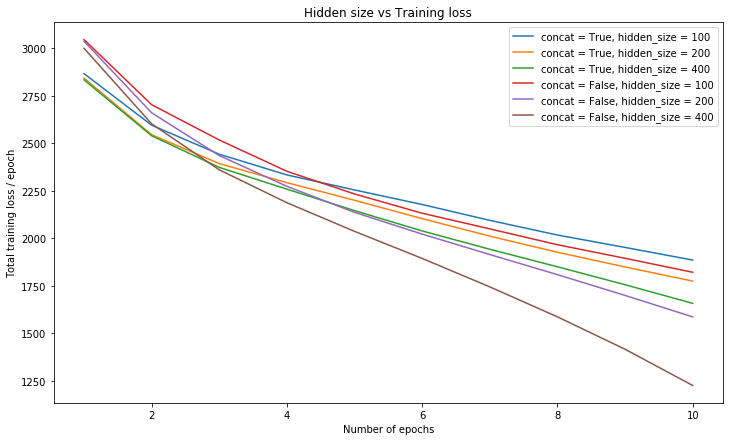

In [28]:
fig = plt.figure(1,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
for i in range(0,len(train_loss)):
    if i < 3:
        plt.plot(x_rge,train_loss[i],label="concat = True, hidden_size = {}".format(hidden_list[i]))
    else:
        plt.plot(x_rge,train_loss[i],label="concat = False, hidden_size = {}".format(hidden_list[i-3]))        

# plt.xlim(0,350)
plt.legend(loc=1)
plt.xlabel("Number of epochs")
plt.ylabel("Total training loss / epoch")
plt.title("Hidden size vs Training loss")
plt.savefig("gru_train_loss.png")
plt.show()

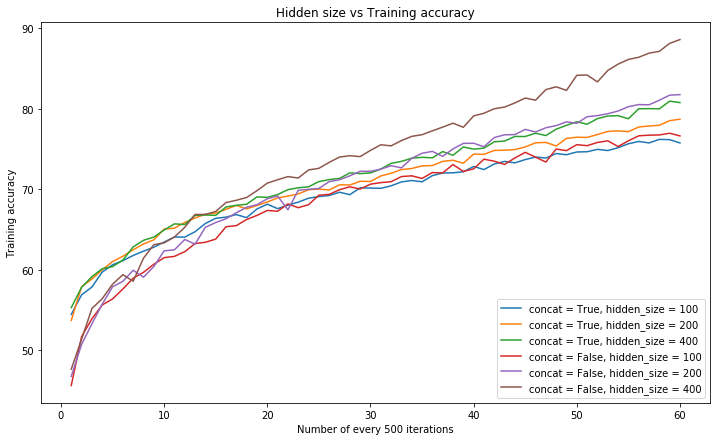

In [31]:
fig = plt.figure(2,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(train_acc)):
    if i < 3:
        plt.plot(x_rge,train_acc[i],label="concat = True, hidden_size = {}".format(hidden_list[i]))
    else:
        plt.plot(x_rge,train_acc[i],label="concat = False, hidden_size = {}".format(hidden_list[i-3]))        

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Training accuracy")
plt.title("Hidden size vs Training accuracy")
plt.savefig("gru_train_acc.png")
plt.show()

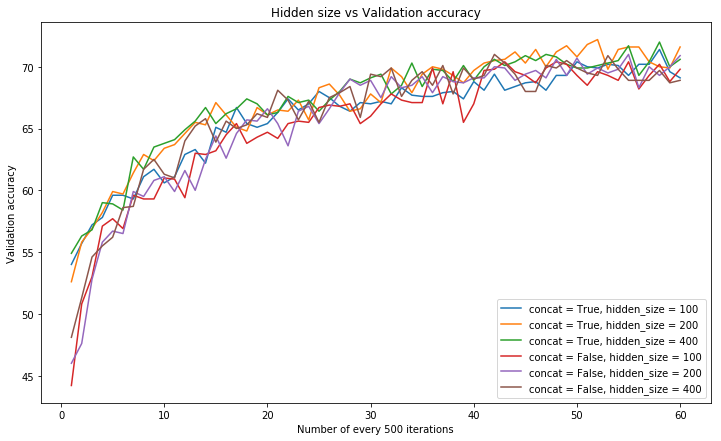

In [33]:
fig = plt.figure(3,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(valid_acc)):
    if i < 3:
        plt.plot(x_rge,valid_acc[i],label="concat = True, hidden_size = {}".format(hidden_list[i]))
    else:
        plt.plot(x_rge,valid_acc[i],label="concat = False, hidden_size = {}".format(hidden_list[i-3]))        

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Validation accuracy")
plt.title("Hidden size vs Validation accuracy")
plt.savefig("gru_val_acc.png")
plt.show()

best config: concat sentences, hidden dimension 200 : 72.2

## CNN

In [20]:
class CNN(nn.Module):
    def __init__(self, embeddings, emb_size, hidden_size, num_classes, kernel_dim, linear_size, multiply):

        super(CNN, self).__init__()

        self.hidden_size, self.multiply = hidden_size, multiply
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
#         self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_dim, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_dim, padding=1)
        if self.multiply:
            self.linear1 = nn.Linear(hidden_size, linear_size)
        else:
            self.linear1 = nn.Linear(hidden_size * 2, linear_size)
        self.linear2 = nn.Linear(linear_size, num_classes)

    def forward(self, s1, s2, len1, len2):
        batch_size, seq_len_1 = s1.size()
        batch_size, seq_len_2 = s2.size()

        # get embedding of words
        embed_1 = self.embedding(s1).float()
        embed_2 = self.embedding(s2).float()
        
        # perform convolution 1
        hidden_1 = self.conv1(embed_1.transpose(1,2)).transpose(1,2)
        hidden_2 = self.conv1(embed_2.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, hidden_1.size(1), hidden_1.size(-1))
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, hidden_2.size(1), hidden_2.size(-1))
#         hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, seq_len_1, hidden_1.size(-1))
#         hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, seq_len_2, hidden_2.size(-1))

        # perform convolution 2
        hidden_1 = self.conv2(hidden_1.transpose(1,2)).transpose(1,2)
        hidden_2 = self.conv2(hidden_2.transpose(1,2)).transpose(1,2)
        hidden_2 = self.conv1(embed_2.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, hidden_1.size(1), hidden_1.size(-1))
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, hidden_2.size(1), hidden_2.size(-1))
#         hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, seq_len_1, hidden_1.size(-1))
#         hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, seq_len_2, hidden_2.size(-1))

        # max pool the hidden state on the seq_len dimension
        hidden_1,_ = hidden_1.max(dim=1)
        hidden_2,_ = hidden_2.max(dim=1)
        
        # concatenate two hidden representations and compute FC layer
        if self.multiply:
            combine_input = torch.mul(hidden_1,hidden_2)
        else:
            combine_input = torch.cat((hidden_1,hidden_2), dim=1)
        out = self.linear1(combine_input)
        out = F.relu(out)
        logits = self.linear2(out)
        return logits
 

In [26]:
def train_cnn(hidden_size, kernel_size=3, multiply=False):
    train_loss = []
    validation_acc = []
    train_accuracy = []

    model = CNN(embeddings=torch.from_numpy(np.array(embedding)), hidden_size=hidden_size, kernel_dim=kernel_size, 
                emb_size=300, num_classes=3, linear_size=100, multiply=multiply)
    if torch.cuda.is_available and torch.has_cudnn:
        model.cuda()

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (s1,s2,len1,len2,labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(s1,s2,len1,len2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # validate every 500 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                validation_acc.append(val_acc)
                train_accuracy.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
#                 with open('cnn_concat.txt','a') as file:
#                     file.write('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}\n'.format(
#                            epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
        train_loss.append(epoch_loss)
    # save the model
#     torch.save(model.state_dict(), os.getcwd()+'/best_cnn.p')
    
    return train_loss, validation_acc, train_accuracy, model

In [37]:
cnn_hidden_list = [100, 200, 400, 600]

cnn_train_loss = []
cnn_valid_acc = []
cnn_train_acc = []
for hid_size in cnn_hidden_list:
    print('hidden size: {}'.format(hid_size))
    with open('cnn_hidden.txt','a') as file:
        file.write('\n\n\nhidden dimension: {}\n'.format(hid_size))
    tr_loss,val_acc,tr_acc = train_cnn(hid_size)
    cnn_train_loss.append(tr_loss)
    cnn_valid_acc.append(val_acc)
    cnn_train_acc.append(tr_acc)
    
for i in range(len(cnn_hidden_list)):
    with open('cnn_hidden.txt','a') as file:
        file.write('\nmaximum accuracy of hidden dimension {}: {}\n'.format(cnn_hidden_list[i], max(cnn_valid_acc[i])))

pkl.dump(cnn_train_loss, open('cnn_trloss_hidden.p', 'wb'))
pkl.dump(cnn_valid_acc, open('cnn_val_hidden.p', 'wb'))
pkl.dump(cnn_train_acc, open('cnn_tracc_hidden.p', 'wb'))

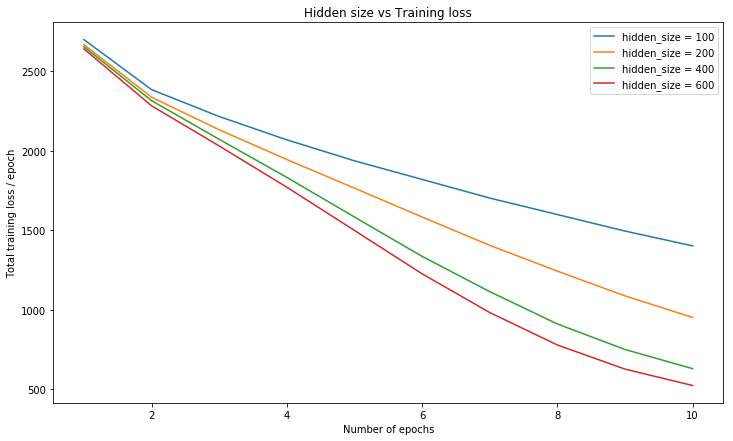

In [38]:
fig = plt.figure(4,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
for i in range(0,len(cnn_train_loss)):
    plt.plot(x_rge,cnn_train_loss[i],label="hidden_size = {}".format(cnn_hidden_list[i]))       

# plt.xlim(0,350)
plt.legend(loc=1)
plt.xlabel("Number of epochs")
plt.ylabel("Total training loss / epoch")
plt.title("Hidden size vs Training loss")
plt.savefig("cnn_trloss_hidden.png")
plt.show()

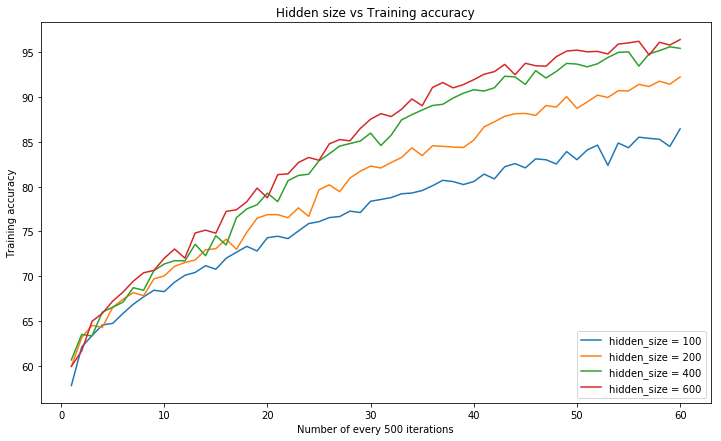

In [46]:
fig = plt.figure(5,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(cnn_train_acc)):
    plt.plot(x_rge,cnn_train_acc[i],label="hidden_size = {}".format(cnn_hidden_list[i]))      

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Training accuracy")
plt.title("Hidden size vs Training accuracy")
plt.savefig("cnn_tracc_hidden.png")
plt.show()

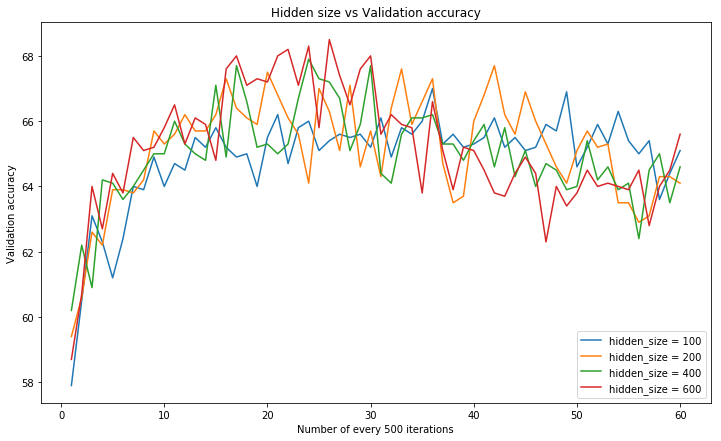

In [47]:
fig = plt.figure(6,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(cnn_valid_acc)):
    plt.plot(x_rge,cnn_valid_acc[i],label="hidden_size = {}".format(cnn_hidden_list[i]))    

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Validation accuracy")
plt.title("Hidden size vs Validation accuracy")
plt.savefig("cnn_val_hidden.png")
plt.show()

best config: hidden size 600: 68.5

In [53]:
cnn_kernel_list = [2,3,5]

cnn_train_ker = []
cnn_valid_ker = []
cnn_tracc_ker = []
for kernel in cnn_kernel_list:
    print('kernel size: {}'.format(kernel))
    with open('cnn_kernel.txt','a') as file:
        file.write('\n\n\nkernel size: {}\n'.format(kernel))
    tr_loss,val_acc,tr_acc = train_cnn(600,kernel_size=kernel)
    cnn_train_ker.append(tr_loss)
    cnn_valid_ker.append(val_acc)
    cnn_tracc_ker.append(tr_acc)
    
for i in range(len(cnn_kernel_list)):
    with open('cnn_kernel.txt','a') as file:
        file.write('\nmaximum accuracy of kernel size {}: {}\n'.format(cnn_kernel_list[i], max(cnn_valid_ker[i])))
        
pkl.dump(cnn_train_ker, open('cnn_trloss_kernel.p', 'wb'))
pkl.dump(cnn_valid_ker, open('cnn_val_kernel.p', 'wb'))
pkl.dump(cnn_tracc_ker, open('cnn_tracc_kernel.p', 'wb'))

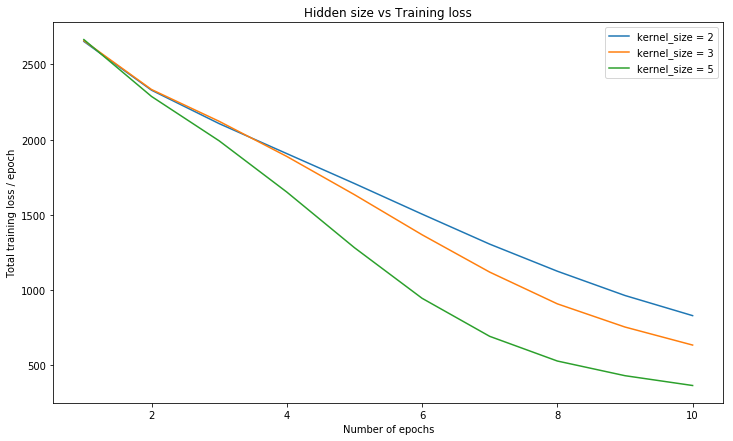

In [52]:
fig = plt.figure(7,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
for i in range(0,len(cnn_train_ker)):
    plt.plot(x_rge,cnn_train_ker[i],label="kernel_size = {}".format(cnn_kernel_list[i]))       

# plt.xlim(0,350)
plt.legend(loc=1)
plt.xlabel("Number of epochs")
plt.ylabel("Total training loss / epoch")
plt.title("Hidden size vs Training loss")
plt.savefig("cnn_trloss_kernel.png")
plt.show()

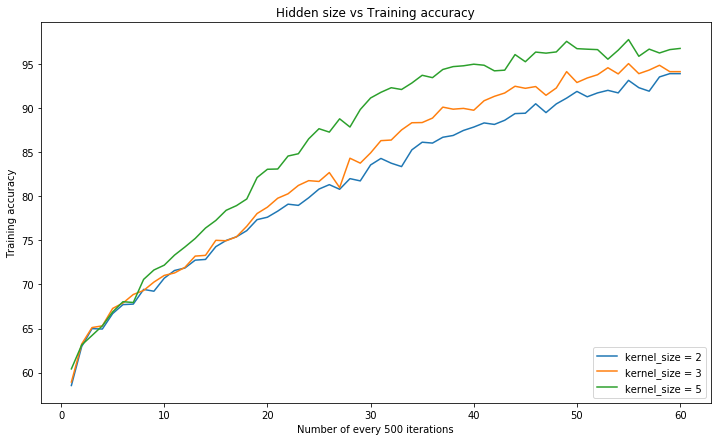

In [54]:
fig = plt.figure(8,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(cnn_tracc_ker)):
    plt.plot(x_rge,cnn_tracc_ker[i],label="kernel_size = {}".format(cnn_kernel_list[i]))      

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Training accuracy")
plt.title("Hidden size vs Training accuracy")
plt.savefig("cnn_tracc_kernel.png")
plt.show()

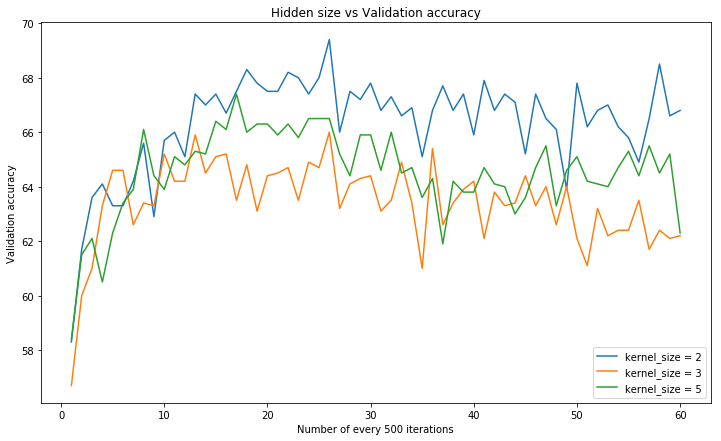

In [55]:
fig = plt.figure(9,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(cnn_valid_ker)):
    plt.plot(x_rge,cnn_valid_ker[i],label="kernel_size = {}".format(cnn_kernel_list[i]))    

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Validation accuracy")
plt.title("Hidden size vs Validation accuracy")
plt.savefig("cnn_val_kernel.png")
plt.show()

best config: hidden size 600, kernel size 2: 69.4

In [59]:
cnn_concat = [False,True]

cnn_train_cat = []
cnn_valid_cat = []
cnn_tracc_cat = []
for mul in cnn_concat:
    print('multiply sentences: {}'.format(mul))
    with open('cnn_concat.txt','a') as file:
        file.write('\n\n\nmultiply sentences: {}\n'.format(mul))
    tr_loss,val_acc,tr_acc = train_cnn(600,kernel_size=2,multiply=mul)
    cnn_train_cat.append(tr_loss)
    cnn_valid_cat.append(val_acc)
    cnn_tracc_cat.append(tr_acc)
    
for i in range(len(cnn_concat)):
    with open('cnn_concat.txt','a') as file:
        file.write('\nmaximum accuracy of multiply sentences {}: {}\n'.format(cnn_concat[i], max(cnn_valid_cat[i])))
        
pkl.dump(cnn_train_cat, open('cnn_trloss_cat.p', 'wb'))
pkl.dump(cnn_valid_cat, open('cnn_val_cat.p', 'wb'))
pkl.dump(cnn_tracc_cat, open('cnn_tracc_cat.p', 'wb'))

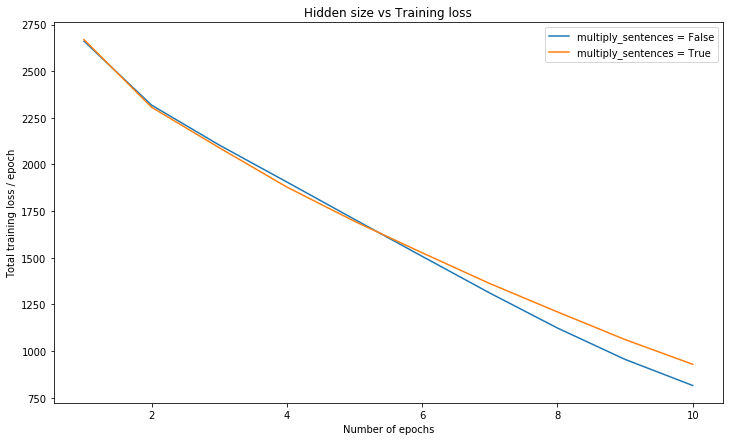

In [60]:
fig = plt.figure(10,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
for i in range(0,len(cnn_train_cat)):
    plt.plot(x_rge,cnn_train_cat[i],label="multiply_sentences = {}".format(cnn_concat[i]))       

# plt.xlim(0,350)
plt.legend(loc=1)
plt.xlabel("Number of epochs")
plt.ylabel("Total training loss / epoch")
plt.title("Hidden size vs Training loss")
plt.savefig("cnn_trloss_cat.png")
plt.show()

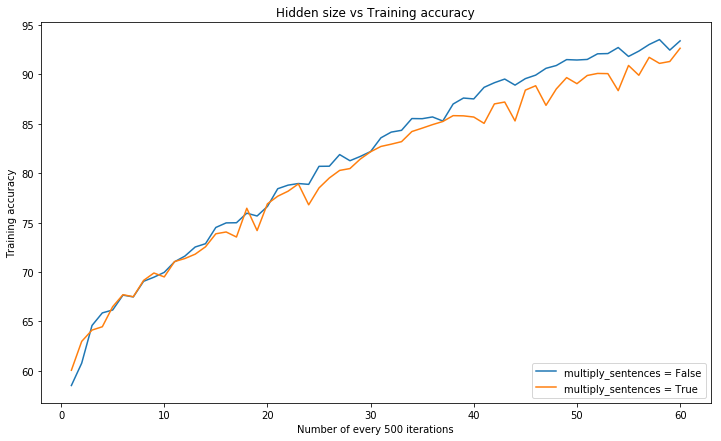

In [62]:
fig = plt.figure(11,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(cnn_tracc_cat)):
    plt.plot(x_rge,cnn_tracc_cat[i],label="multiply_sentences = {}".format(cnn_concat[i]))      

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Training accuracy")
plt.title("Hidden size vs Training accuracy")
plt.savefig("cnn_tracc_cat.png")
plt.show()

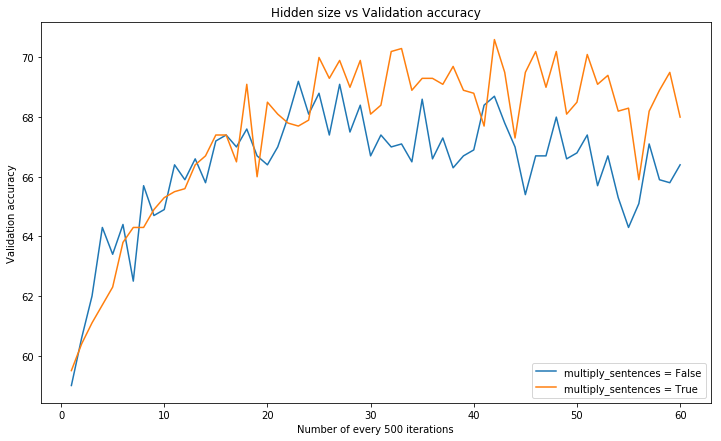

In [63]:
fig = plt.figure(12,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,61))
for i in range(0,len(cnn_valid_cat)):
    plt.plot(x_rge,cnn_valid_cat[i],label="multiply_sentences = {}".format(cnn_concat[i]))    

# plt.xlim(0,350)
plt.legend(loc=4)
plt.xlabel("Number of every 500 iterations")
plt.ylabel("Validation accuracy")
plt.title("Hidden size vs Validation accuracy")
plt.savefig("cnn_val_cat.png")
plt.show()

best config: hidden size 600, kernel size 2, multiply sentences True: 70.6

### Get prediction from best overall model
- a GRU model with hidden size 200 and concat two sentences

In [21]:
def get_prediction(loader, model):
    index_arr = []
    pred_list = []
    model.eval()
    for s1,s2,len1,len2,labels in loader:
#         data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(s1,s2,len1,len2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        pred_list.append(predicted.cpu().numpy().flatten())
        equal_label = torch.eq(predicted.view_as(labels),labels)
        index_arr.append(np.argwhere(equal_label.cpu().numpy()).flatten())
    return index_arr, pred_list

In [22]:
device = torch.device("cuda")
gru = RNN(embeddings=torch.from_numpy(np.array(embedding)),emb_size=300,hidden_size=200,
                num_layers=1,num_classes=3,linear_size=100,multiply=False)
gru.load_state_dict(torch.load(os.getcwd()+'/best_gru.p'))
gru.to(device)

RNN(
  (embedding): Embedding(999996, 300)
  (rnn): GRU(300, 200, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [23]:
idx_arr, pred = get_prediction(val_loader, gru)

In [24]:
idx_arr[0] # incorrect: 0, 5, 18 correct: 10, 15, 29

array([ 1,  3,  4,  6,  7,  8,  9, 10, 12, 14, 15, 16, 17, 19, 21, 22, 25,
       27, 28, 29, 30])

In [43]:
pred[0]

array([1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2,
       1, 0, 2, 2, 2, 1, 1, 2, 2, 0])

In [54]:
snli_val.iloc[:10]

,sentence1,sentence2,label
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment
3,Man in overalls with two horses .,a man in overalls with two horses,entailment
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment
5,Two people are in a green forest .,The forest is not dead .,entailment
6,Two men are listening to music through headpho...,Two men listen to music .,entailment
7,"Two women , one walking her dog the other push...",There is a snowstorm .,contradiction
8,A group of numbered participants walk down the...,Participants wait for the beginning of the wal...,neutral
9,Three people and a white dog are sitting in th...,Three dogs and a person are sitting in the snow .,contradiction


In [53]:
val_target[:10]

array([0, 1, 1, 1, 1, 1, 1, 0, 2, 0])

## Evaluate on MNLI dataset

In [28]:
path_mnli_tr = os.getcwd() + '/hw2_data/mnli_train.tsv'
path_mnli_val = os.getcwd() + '/hw2_data/mnli_val.tsv'

In [29]:
mnli_train = pd.read_csv(path_mnli_tr,sep='\t')
mnli_val = pd.read_csv(path_mnli_val,sep='\t')

In [30]:
mnli_val.head()

,sentence1,sentence2,label,genre
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government


In [31]:
mnli_val.genre.unique()

array(['fiction', 'telephone', 'slate', 'government', 'travel'],
      dtype=object)

In [32]:
group = mnli_val.groupby('genre')

In [33]:
gp = []
key = []
for g in group:
    key.append(g[0])
    gp.append(g[1])

In [34]:
key

['fiction', 'government', 'slate', 'telephone', 'travel']

In [35]:
test_list = []
for g in gp:
    s1 = tokenize_dataset(g.sentence1.values)
    s2 = tokenize_dataset(g.sentence2.values)
    label = g.label.values
    _,target,_ = convert_label(train_label,label)
    test_list.append(zip(s1,s2,target))

In [36]:
# build dataloaders by genre
test_loader = []
for datum in test_list:
    dataset = VocabDataset(datum, word2idx)
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    test_loader.append(loader)

### load best gru and cnn model

In [21]:
device = torch.device("cuda")
gru = RNN(embeddings=torch.from_numpy(np.array(embedding)),emb_size=300,hidden_size=200,
                num_layers=1,num_classes=3,linear_size=100,multiply=False)
gru.load_state_dict(torch.load(os.getcwd()+'/best_gru.p'))
gru.to(device)

RNN(
  (embedding): Embedding(999996, 300)
  (rnn): GRU(300, 200, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [27]:
device = torch.device("cuda")
cnn = CNN(embeddings=torch.from_numpy(np.array(embedding)),emb_size=300,hidden_size=600,
                num_classes=3,kernel_dim=2,linear_size=100,multiply=True)
cnn.load_state_dict(torch.load(os.getcwd()+'/best_cnn.p'))
cnn.to(device)

CNN(
  (embedding): Embedding(999996, 300)
  (conv1): Conv1d(300, 600, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv2): Conv1d(600, 600, kernel_size=(2,), stride=(1,), padding=(1,))
  (linear1): Linear(in_features=600, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [37]:
mnli_gru_acc = []
mnli_cnn_acc = []
for t in test_loader:
    mnli_gru_acc.append(test_model(t,gru))
    mnli_cnn_acc.append(test_model(t,cnn))

In [40]:
print('GRU accuracy on MNLI')
for i in range(len(key)):
    print('{}: {}'.format(key[i],mnli_gru_acc[i]))

GRU accuracy on MNLI
fiction: 51.256281407035175
government: 47.145669291338585
slate: 45.70858283433134
telephone: 48.95522388059702
travel: 45.31568228105906


In [41]:
print('CNN accuracy on MNLI')
for i in range(len(key)):
    print('{}: {}'.format(key[i],mnli_cnn_acc[i]))

CNN accuracy on MNLI
fiction: 45.92964824120603
government: 44.58661417322835
slate: 40.7185628742515
telephone: 45.67164179104478
travel: 43.9918533604888
